In [2]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [3]:
#two channels, do k-bit, M-ary generalisation. starting with k=4 for 16 symbols
n = 2
k = 6
M = 2**k
R = k/n
channel_noise_dB=26
channel_noise_ratio = 10**(channel_noise_dB/10)
PD_noise_dB=16
PD_noise_ratio = 10**(PD_noise_dB/10)
CD_noise_dB=16
CD_noise_ratio = 10**(CD_noise_dB/10)
noise_mag1 = np.sqrt(1/(2*R*channel_noise_ratio))
PDnoise_mag = 1/(2*R*PD_noise_ratio)
CDnoise_mag = np.sqrt(1/(2*R*CD_noise_ratio))
print(noise_mag1)
print('PDprocessing:',PDnoise_mag)
print('CDprocessing:',CDnoise_mag)

0.020460883133064663
PDprocessing: 0.004186477385849299
CDprocessing: 0.06470299363900638


In [4]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])

verification checks:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
#Custom layer definition
class EnergySplitter(keras.layers.Layer):
  '''
  Creates two copies of the input, concatenated onto one dimension, each 
  multiplied by a constant. The parameter rho is trainable.
  The first copy of the input is multiplied by (1-rho), while the second is
  multiplied by rho.
  '''
  ##TODO: MOdyify for sqrt(rho)
  def compute_output_shape(self,input_shape):
    return [input_shape,input_shape]
  
  def __init__(self,**kwargs):
    super(EnergySplitter,self).__init__(**kwargs)
    #initialise the splitting ratio
    self.rho=tf.Variable(
        initial_value=0.5,  
        trainable=True,
        constraint=lambda t: tf.clip_by_value(t,0,0.999)
    )

  def call(self,inputs):
    return [K.sqrt(1-self.rho)*inputs,K.sqrt(self.rho)*inputs]

class SquareSum(keras.layers.Layer):
  '''
  returns a scalar value, the sum of the elementwise squared input
  '''
  def compute_output_shape(self, input_shape):
    return (None,1)
  
  def __init__(self, **kwargs):
    super(SquareSum,self).__init__(**kwargs)
  
  def call(self, inputs):
    return K.reshape(tf.convert_to_tensor([K.sum(K.square(inputs),axis=1)],dtype='float32'),shape=(tf.shape(inputs)[0],1))

In [6]:
#Build the model:

#input
autoenc_in = keras.layers.Input(shape=(M,))

#encoder
encoder_0 = keras.layers.Dense(M,activation='relu')(autoenc_in)
encoder_1 = keras.layers.Dense(n,activation='linear')(encoder_0)

#Regulariser
regulariser = keras.layers.BatchNormalization(center=False,scale=False)(encoder_1)

#Channel noise
channel = keras.layers.GaussianNoise(noise_mag1)(regulariser)

#Splitter
splitter_layer = EnergySplitter(name='Splitter')
splitter = splitter_layer(channel)

#PD processing
presquaring = SquareSum()(splitter[0])
PD_noise = keras.layers.GaussianNoise(PDnoise_mag,name='PD_noise')(presquaring)

#CD processing
CD_noise = keras.layers.GaussianNoise(CDnoise_mag,name='CD_noise')(splitter[1])

#Try adding pre-processing to do something with each pathway before merging
PD_preproc = keras.layers.Dense(M,activation='relu',name='PD_Preprocessing')(PD_noise)
CD_preproc = keras.layers.Dense(M,activation='relu',name='CD_Preprocessing')(CD_noise)

#Merge two inputs
Merge = keras.layers.Concatenate(axis=-1,name='Merge')([PD_preproc,CD_preproc])

#decoder
decoder_0 = keras.layers.Dense(M,activation='relu')(Merge)
decoder_1 = keras.layers.Dense(M,activation='softmax')(decoder_0)

#Put it together
autoencoder = keras.models.Model(autoenc_in,decoder_1)
print(autoencoder.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           4160        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            130         dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2)            4           dense_1[0][0]                    
______________________________________________________________________________________________

In [0]:
#keras.utils.plot_model(
#    autoencoder,
#    to_file='modelmap.png'
#)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [9]:
autoencoder.fit(xs,xs,batch_size=100*M,epochs=50)
autoencoder.fit(xs,xs,batch_size=100*M,epochs=50)

Epoch 1/50
100/100 [==============================] - 3s 30ms/step - loss: 3.3061
Epoch 2/50
100/100 [==============================] - 3s 29ms/step - loss: 1.2637
Epoch 3/50
100/100 [==============================] - 3s 29ms/step - loss: 0.4230
Epoch 4/50
100/100 [==============================] - 3s 29ms/step - loss: 0.1641
Epoch 5/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0836
Epoch 6/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0510
Epoch 7/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0350
Epoch 8/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0257
Epoch 9/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0205
Epoch 10/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0163
Epoch 11/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0137
Epoch 12/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0120
Epoch 13/50
1

In [0]:
#Make subordinate models for plotting/simulation
encoder = keras.models.Model(autoenc_in,regulariser)

#Make the decoder from the concatenation onwards: 
deco_in = [keras.layers.Input(shape=(1,)),keras.layers.Input(shape=(2,))]
deco_PD_in = keras.layers.Input(shape=(1,))
deco_CD_in = keras.layers.Input(shape=(2,))
deco_PD = autoencoder.layers[-5](deco_PD_in)
deco_CD = autoencoder.layers[-4](deco_CD_in)
deco = autoencoder.layers[-3]([deco_PD,deco_CD])
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
decoder = keras.models.Model([deco_PD_in,deco_CD_in],deco)

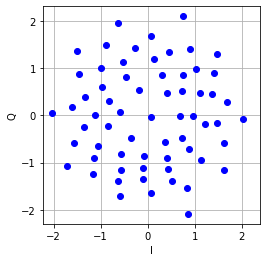

rho = 0.7022033
PD proportion = 0.545707546426478
CD proportion = 0.8379757


In [11]:
#Plot modulation scheme
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = data.reshape(M,2,1)
plt.plot(data[:,0],data[:,1],'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('square')
plt.show()
rho=splitter_layer.get_weights()[0]
print('rho =',rho)
print('PD proportion =',np.sqrt(1-rho))
print('CD proportion =',np.sqrt(rho))

In [12]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1,0,0]**2+data[iter1,1,0]**2
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use/n)
print('scaling, should be around 1, =',scaling)

2.049499963864138
scaling, should be around 1, = 1.0122993539126994


In [13]:
'''# Monte-Carlo Modelling
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(0,16,1.5))
EbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])
EbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])
ser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))
for iter1 in range(len(EbNo_range_dB_channel)):
  for iter2 in range(len(EbNo_range_dB_PD)):
    for iter3 in range(len(EbNo_range_dB_CD)):
      # Create channel noise vector
      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)
      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
      noise_channel = noise_std_channel*np.random.randn(dat_size,n)
      # Create PD noise vector
      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)
      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling
      noise_PD = noise_std_PD*np.random.randn(dat_size)
      # Create CD noise vector
      EbNo_CD = 10**(EbNo_range_dB_CD[iter3]/10)
      noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
      noise_CD = noise_std_CD*np.random.randn(dat_size,n)
      # Get encoder output and add channel noise
      channel_out=encoder.predict(xs)+noise_channel
      # PD section
      PD_input = channel_out*np.sqrt(1-rho)
      PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
      PD_out = PD_squared+noise_PD
      # CD section, literally just add more noise to scaled input
      CD_out = channel_out*np.sqrt(rho)+noise_CD
      # Prediction based on noises
      prediction = decoder.predict([PD_out,CD_out])
      prediction = np.argmax(prediction,axis=1)
      wrong = (prediction != rand_data)
      count=np.sum(wrong)
      index=iter3+len(EbNo_range_dB_CD)*iter2+len(EbNo_range_dB_CD)*len(EbNo_range_dB_PD)*iter1
      ser[index]=count/dat_size
      print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_range_dB_PD[iter2],'| CD EbNo(dB):',EbNo_range_dB_CD[iter3],'| SER',ser[index])
      '''

"# Monte-Carlo Modelling\nrho=splitter_layer.get_weights()[0]\n# Three ebno amounts, which can vary separately. Express as a list even if a \n# single value. In practice, only make longer than 1, fix the other two for plotting\nEbNo_range_dB_channel = list(np.arange(0,16,1.5))\nEbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])\nEbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])\nser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))\nfor iter1 in range(len(EbNo_range_dB_channel)):\n  for iter2 in range(len(EbNo_range_dB_PD)):\n    for iter3 in range(len(EbNo_range_dB_CD)):\n      # Create channel noise vector\n      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)\n      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling\n      noise_channel = noise_std_channel*np.random.randn(dat_size,n)\n      # Create PD noise vector\n      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)\n      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling\n      noise

In [0]:
dat_size=M*15000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)

In [15]:
# Monte-Carlo Modelling for processing noise consistent relative to channel noise
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(22,30,1))
EbNo_dB_PD_diff = PD_noise_dB - channel_noise_dB
EbNo_dB_CD_diff = CD_noise_dB - channel_noise_dB
ser = [None]*len(EbNo_range_dB_channel)
for iter1 in range(len(EbNo_range_dB_channel)):
  # Create channel noise vector
  EbNo_channel_dB=EbNo_range_dB_channel[iter1]
  EbNo_channel = 10**(EbNo_channel_dB/10)
  noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
  noise_channel = noise_std_channel*np.random.randn(dat_size,n)
  # Create PD noise vector
  EbNo_PD = 10**((EbNo_dB_PD_diff+EbNo_channel_dB)/10)
  noise_std_PD = 1/(2*R*EbNo_PD)*scaling
  noise_PD = noise_std_PD*np.random.randn(dat_size)
  # Create CD noise vector
  EbNo_CD = 10**((EbNo_dB_CD_diff+EbNo_channel_dB)/10)
  noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
  noise_CD = noise_std_CD*np.random.randn(dat_size,n)
  # Get encoder output and add channel noise
  channel_out=encoder.predict(xs)+noise_channel
  # PD section
  PD_input = channel_out*np.sqrt(1-rho)
  PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
  PD_out = PD_squared+noise_PD
  # CD section, literally just add more noise to scaled input
  CD_out = channel_out*np.sqrt(rho)+noise_CD
  # Prediction based on noises
  prediction = decoder.predict([PD_out,CD_out])
  prediction = np.argmax(prediction,axis=1)
  wrong = (prediction != rand_data)
  count=np.sum(wrong)
  ser[iter1]=count/dat_size
  print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_dB_PD_diff+EbNo_channel_dB,'| CD EbNo(dB):',EbNo_dB_CD_diff+EbNo_channel_dB,'| SER',ser[iter1])

Channel EbNo(dB): 22 | PD EbNo(dB): 12 | CD EbNo(dB): 12 | SER 0.01829375
Channel EbNo(dB): 23 | PD EbNo(dB): 13 | CD EbNo(dB): 13 | SER 0.008321875
Channel EbNo(dB): 24 | PD EbNo(dB): 14 | CD EbNo(dB): 14 | SER 0.0031947916666666665
Channel EbNo(dB): 25 | PD EbNo(dB): 15 | CD EbNo(dB): 15 | SER 0.001065625
Channel EbNo(dB): 26 | PD EbNo(dB): 16 | CD EbNo(dB): 16 | SER 0.0003083333333333333
Channel EbNo(dB): 27 | PD EbNo(dB): 17 | CD EbNo(dB): 17 | SER 4.791666666666667e-05
Channel EbNo(dB): 28 | PD EbNo(dB): 18 | CD EbNo(dB): 18 | SER 1.0416666666666666e-05
Channel EbNo(dB): 29 | PD EbNo(dB): 19 | CD EbNo(dB): 19 | SER 2.0833333333333334e-06


In [16]:
#sandbox
print(ser)
print(rho)


[0.01829375, 0.008321875, 0.0031947916666666665, 0.001065625, 0.0003083333333333333, 4.791666666666667e-05, 1.0416666666666666e-05, 2.0833333333333334e-06]
0.7022033
